In [2]:
import pandas as pd
import scipy
import numpy as np
import scipy.sparse as sp
import scipy.io as spio

from scipy.stats import pearsonr

import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.collections as collections

import isolearn.io as isoio

from analyze_aparent_designed_mpra_helpers import *


<h2>Load collapsed designed MPRA data</h2>

In [3]:
#Load designed MPRA data (Collapsed over experiment replicates)
seq_dict = isoio.load('../data/prepared_data/apa_array_data/apa_array_data_master_seq')
print("n = " + str(len(seq_dict['array_df'])))
print('Avg read count (avg over barcodes) = ' + str(np.mean(seq_dict['array_df'].query("n_barcodes >= 2")['mean_total_count'])))
print('Pooled read count (pooled over barcodes) = ' + str(np.mean(seq_dict['array_df'].query("n_barcodes >= 2")['pooled_total_count'])))

#Load variant dataframe
variant_dict = isoio.load('../data/prepared_data/apa_variant_data/apa_variant_data_master_seq')
print("n (variants) = " + str(len(variant_dict['variant_df'])))

#Load predictions
model_name = 'aparent_theano_legacy_30_31_34_pasaligned'
pred_dict = isoio.load('predictions/apa_array_data_legacy/' + model_name + '_predictions_master_seq')

#Join mpra dataframes with prediction table and calculate cut probabilities
seq_df, variant_df = append_predictions(seq_dict['array_df'], seq_dict['pooled_cuts'], variant_dict['variant_df'], variant_dict['pooled_cuts_var'], variant_dict['pooled_cuts_ref'], pred_dict['array_df'], pred_dict['cut_prob'])


n = 39833
Avg read count (avg over barcodes) = 431.92676310713546
Pooled read count (pooled over barcodes) = 3656.5562880452626
n (variants) = 21734


<h2>Rare Functional Variant Detailed analysis</h2>

In [4]:
variant_df_filtered = variant_df.query("n_barcodes_var >= 5 and n_barcodes_ref >= 5 and mean_total_count_var >= 200 and mean_total_count_ref >= 200")

#Filter on human variants
included_experiments = ['acmg_apadb', 'acmg_polyadb', 'sensitive_genes', 'clinvar_wt', 'human_variant']

filter_query = ""

for exp_index, included_experiment in enumerate(included_experiments) :
    filter_query += "experiment == '" + str(included_experiment) + "'"
    if exp_index < len(included_experiments) - 1 :
        filter_query += " or "

human_variant_df = variant_df.query(filter_query).copy()
human_variant_df_filtered = variant_df_filtered.query(filter_query).copy()

human_variant_df['delta_logodds_pred'] = human_variant_df['mean_delta_logodds_pred']
human_variant_df_filtered['delta_logodds_pred'] = human_variant_df_filtered['mean_delta_logodds_pred']


var_df = human_variant_df_filtered.query("variant == 'snv' and snv_pos != -1").copy()

mer6_weights_doubledope = np.load('apa_6mer_weights/apa_6mer_v_general3_antimisprime_orig_pasaligned_margin_doubledope_weights.npy')[1:]
mer6_weights_simple = np.load('apa_6mer_weights/apa_6mer_v_general3_antimisprime_orig_pasaligned_margin_simple_weights.npy')[1:]
mer6_weights_tomm5 = np.load('apa_6mer_weights/apa_6mer_v_general3_antimisprime_orig_pasaligned_margin_tomm5_weights.npy')[1:]

mer6_weights_use = (mer6_weights_tomm5[:4096] + mer6_weights_simple[:4096]) / 2.
mer6_weights_pas = mer6_weights_doubledope[4096:2*4096]
mer6_weights_dse = (mer6_weights_tomm5[2*4096:] + mer6_weights_simple[2*4096:]) / 2.

var_df = append_6mer_delta_logodds_scores(var_df, mer6_weights_use, mer6_weights_pas, mer6_weights_dse)
var_df['delta_logodds_pred'] = var_df['mean_delta_logodds_pred']


<h2>Gain/Loss of CFIm25 Binding site (TGTA)</h2>

Gain of Motif (Neural Net model)


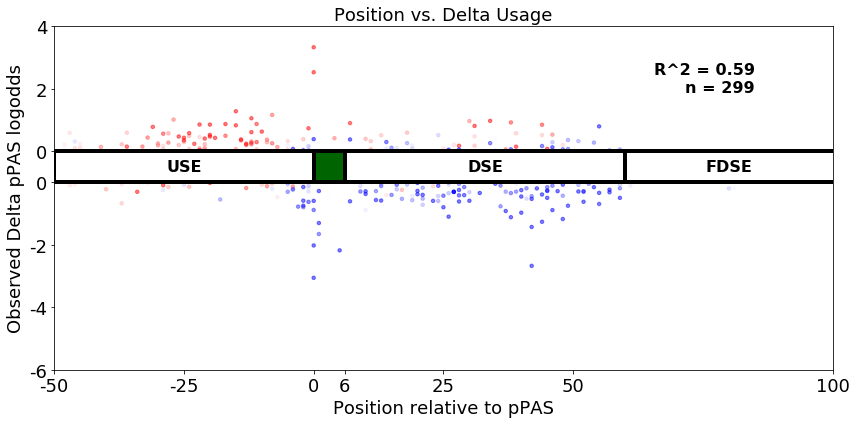

Gain of Motif (Hexamer model)


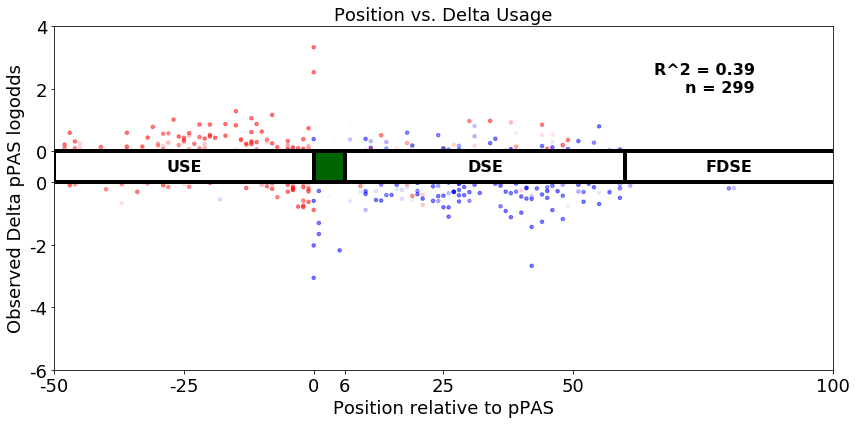


# Gain of ['TGTA'] = 299
# Neural net / Observation agreement = 233
# Neural net / 6-mer model agreement = 243
## Gain of motif in USE = 122
### Gain of motif, Loss of function = 39
### Gain of motif, Gain of function = 83
### Neural net / 6-mer model agreement = 95
## Gain of motif in DSE = 164
### Gain of motif, Loss of function = 109
### Gain of motif, Gain of function = 55
### Neural net / 6-mer model agreement = 138
Loss of Motif (Neural Net model)


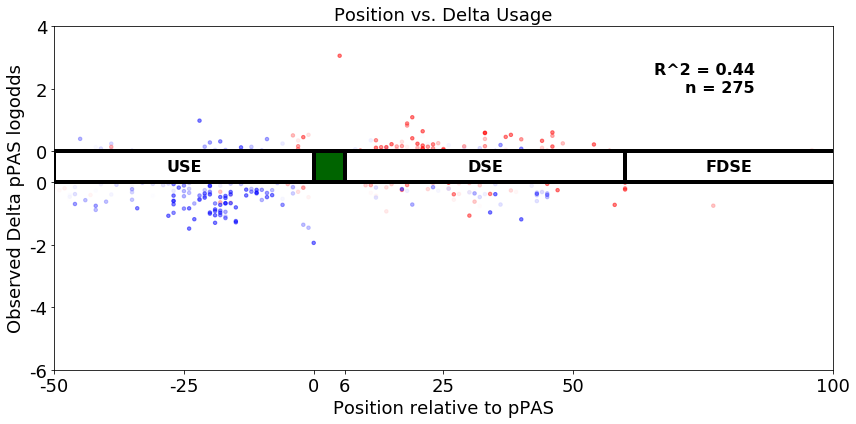

Loss of Motif (Hexamer model)


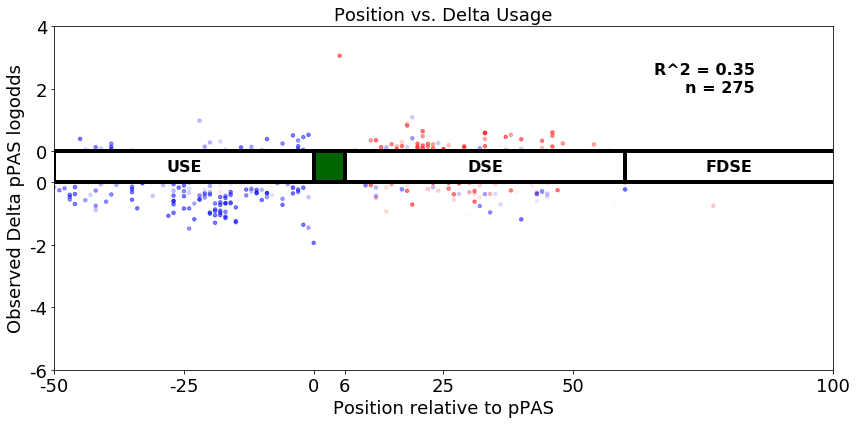


# Loss of ['TGTA'] = 275
# Neural net / Observation agreement = 199
# Neural net / 6-mer model agreement = 220
## Loss of motif in USE = 151
### Loss of motif, Loss of function = 123
### Loss of motif, Gain of function = 28
### Neural net / 6-mer model agreement = 132
## Loss of motif in DSE = 122
### Loss of motif, Loss of function = 61
### Loss of motif, Gain of function = 61
### Neural net / 6-mer model agreement = 86


In [10]:
#Gain/Loss of TGTA
motifs = ['TGTA']
gain_of_motif_df, loss_of_motif_df = plot_gain_loss_of_motifs(var_df, motifs, name_prefix='tgta', plot_logos=False, save_figs=False)


Gain of overlapping TGTA/CSE:
Gene = INS.1
WT seq = CAGCCCGCAGGCAGCCCCACACCCGCCGCCTCCTGCACCGAGAGAGATGGAATAAAGCCCTTGAACCAGCCCTGCTGTGCCGTCTGTGTGTCTTGGGGGCCCTGGGCCAAGCCCCACTTCCCGGCACTGTTGTGAGCCCCTCCCAGCTCTCTCCACGCTCTCTG
SNV pos = 49
SNV nt = T
ClinVar id = Missing


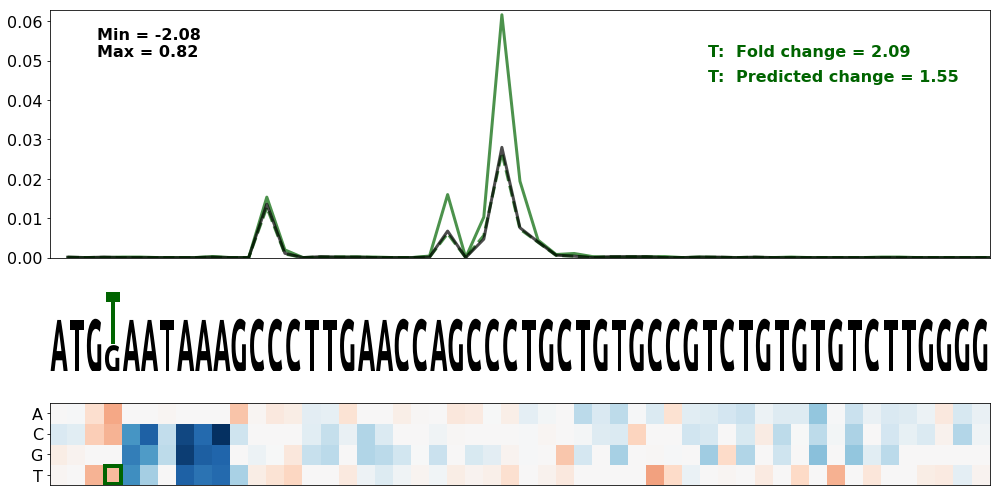

Gene = SNRNP200.3
WT seq = TATAGCATTTTCAGGCATGTTCCTGGTAGTTCTTTTGAGTCTGACATTCTAATAAAATAATTTGTAGAAACCATTTGTCTTTGTAGTGATTCCAAATTAAAAGTTTTCTTTCTCCAACCTGAGGGCACGGCCAAAAAGATCTGGTTATTTTTTAGCCAGGAACG
SNV pos = 48
SNV nt = G
ClinVar id = NM_014014.4(SNRNP200):c.*257C>G


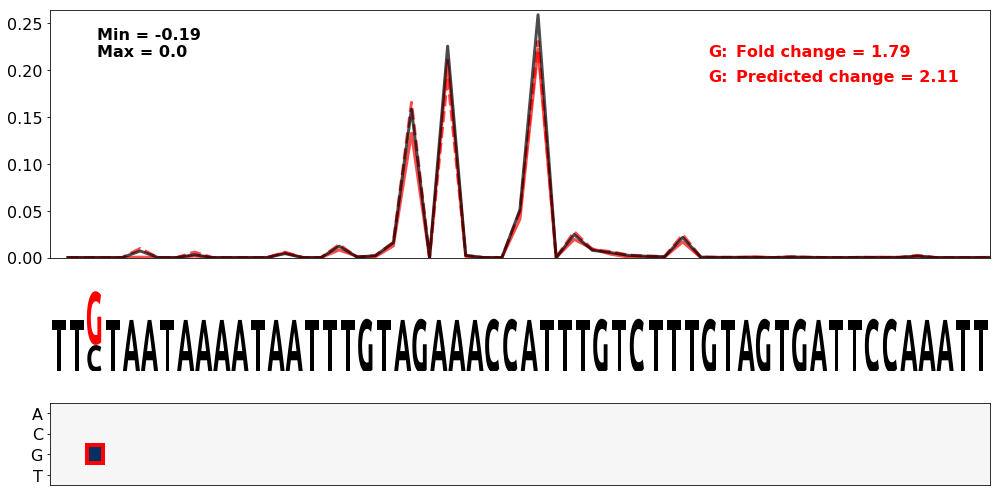

In [11]:
print('Gain of overlapping TGTA/CSE:')

experiment_name = 'gain_of_overlapping_tgta'

gene_names = [
    'INS.1',
    'SNRNP200.3'
]

snv_list = [
    [(49, 'T', 'darkgreen')],
    [(48, 'G', 'red')],
]

wt_seq_list = [
    'CAGCCCGCAGGCAGCCCCACACCCGCCGCCTCCTGCACCGAGAGAGATGGAATAAAGCCCTTGAACCAGCCCTGCTGTGCCGTCTGTGTGTCTTGGGGGCCCTGGGCCAAGCCCCACTTCCCGGCACTGTTGTGAGCCCCTCCCAGCTCTCTCCACGCTCTCTG',
    'TATAGCATTTTCAGGCATGTTCCTGGTAGTTCTTTTGAGTCTGACATTCTAATAAAATAATTTGTAGAAACCATTTGTCTTTGTAGTGATTCCAAATTAAAAGTTTTCTTTCTCCAACCTGAGGGCACGGCCAAAAAGATCTGGTTATTTTTTAGCCAGGAACG'
]

plot_variant_selection(human_variant_df, gene_names, snv_list, wt_seq_list, experiment_name, seq_start=46, seq_end=98, save_figs=False)


In [12]:
#Load position nmer weights and build decoder dicts

simple_pos_weights = np.load('apa_4mer_pos_weights/simple_position_nmer_weights.npy')

mer4_dict, mer4_list = {}, []
bases = list('ACGT')

#Build dictionary of 4-mer -> index
i4 = 0
for b1 in bases :
    for b2 in bases :
        for b3 in bases :
            for b4 in bases :
                mer4_dict[b1 + b2 + b3 + b4] = i4
                mer4_list.append(b1 + b2 + b3 + b4)
                i4 += 1


Wildtype Isoform Abundance vs. Variant Effect


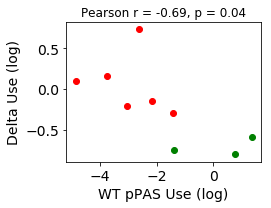

Wildtype Isoform Abundance vs. Variant Effect (4mer scores subtracted from effect size)


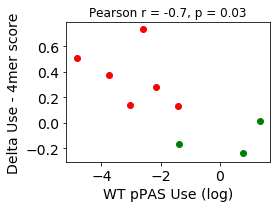

In [13]:
#Compare delta log fold change against wildtype isoform abundance
save_figs = False

tgta_boundary_df = gain_of_motif_df.query("snv_pos >= 47 and snv_pos <= 49")

slice_index = tgta_boundary_df.index.str.slice(47, 50).str.contains('TGT')
slice_index = slice_index & (~tgta_boundary_df.wt_seq.str.slice(0, 45).str.contains('AATAAA'))
slice_index = slice_index & (~tgta_boundary_df.wt_seq.str.slice(0, 45).str.contains('ATTAAA'))
slice_index = slice_index & (~tgta_boundary_df.wt_seq.str.slice(0, 45).str.contains('TATAAA'))
slice_index = slice_index & (~tgta_boundary_df.wt_seq.str.slice(0, 45).str.contains('CATAAA'))
slice_index = slice_index & (~tgta_boundary_df.wt_seq.str.slice(0, 45).str.contains('GATAAA'))
slice_index = slice_index & (~tgta_boundary_df.wt_seq.str.slice(0, 45).str.contains('AGTAAA'))
tgta_boundary_df = tgta_boundary_df[slice_index]

has_up_tgta = tgta_boundary_df.wt_seq.str.slice(0, 45).str.contains('TGTA') | tgta_boundary_df.wt_seq.str.slice(57, 110).str.contains('TGTA')
not_up_tgta = ~(tgta_boundary_df.wt_seq.str.slice(0, 45).str.contains('TGTA') | tgta_boundary_df.wt_seq.str.slice(57, 110).str.contains('TGTA'))

r_val, p_val = pearsonr(tgta_boundary_df['pooled_proximal_logodds_ref'], tgta_boundary_df['delta_logodds_true'])

print("Wildtype Isoform Abundance vs. Variant Effect")

f = plt.figure(figsize=(4, 3))

plt.scatter(tgta_boundary_df['pooled_proximal_logodds_ref'].loc[has_up_tgta], tgta_boundary_df['delta_logodds_true'].loc[has_up_tgta], c='green')
plt.scatter(tgta_boundary_df['pooled_proximal_logodds_ref'].loc[not_up_tgta], tgta_boundary_df['delta_logodds_true'].loc[not_up_tgta], c='red')

plt.xlabel('WT pPAS Use (log)', fontsize=14)
plt.ylabel('Delta Use (log)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Pearson r = ' + str(round(r_val, 2)) + ', p = ' + str(round(p_val, 2)))

plt.tight_layout()

if save_figs :
    fig_name = 'gain_of_overlapping_tgta_scatter'
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')

plt.show()

#Subtract 4mer delta score from measured variant delta fold change
linear_boundary_delta = np.zeros(len(tgta_boundary_df))

i = 0
for index, row in tgta_boundary_df.iterrows() :
    
    var_score = 0
    ref_score = 0
    for offset in range(-3, 3 + 1) :
        var_mer = index[46 + offset: 50 + offset]
        ref_mer = row['wt_seq'][46 + offset: 50 + offset]
        
        rel_pos = 46 + offset
        
        var_score += simple_pos_weights[rel_pos * 256 + mer4_dict[var_mer]]
        ref_score += simple_pos_weights[rel_pos * 256 + mer4_dict[ref_mer]]
    
    linear_boundary_delta[i] = var_score - ref_score
    
    i += 1

r_val, p_val = pearsonr(tgta_boundary_df['pooled_proximal_logodds_ref'], tgta_boundary_df['delta_logodds_true'] - linear_boundary_delta)

print("Wildtype Isoform Abundance vs. Variant Effect (4mer scores subtracted from effect size)")

f = plt.figure(figsize=(4, 3))

plt.scatter(tgta_boundary_df['pooled_proximal_logodds_ref'].loc[has_up_tgta], tgta_boundary_df['delta_logodds_true'].loc[has_up_tgta] - linear_boundary_delta[has_up_tgta], c='green')
plt.scatter(tgta_boundary_df['pooled_proximal_logodds_ref'].loc[not_up_tgta], tgta_boundary_df['delta_logodds_true'].loc[not_up_tgta] - linear_boundary_delta[not_up_tgta], c='red')

plt.xlabel('WT pPAS Use (log)', fontsize=14)
plt.ylabel('Delta Use - 4mer score', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Pearson r = ' + str(round(r_val, 2)) + ', p = ' + str(round(p_val, 2)))

plt.tight_layout()

if save_figs :
    fig_name = 'gain_of_overlapping_tgta_scatter_multi_4mer_correction'
    plt.savefig(fig_name + '.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '.eps')

plt.show()



